In [11]:
import sys
sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [12]:
import pandas as pd
import numpy as np 
import datetime
import json


from anomaly_detector.config import Configuration
from anomaly_detector.storage.storage import DataCleaner
from anomaly_detector.storage.mongodb_storage import MongoDBDataStorageSource
from anomaly_detector.storage.storage_attribute import MGStorageAttribute
from anomaly_detector.model.w2v_model import W2VModel

from bson.json_util import dumps

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re
import string

In [13]:
def config():
    """Initialize configurations before testing."""
    cfg = Configuration()
    cfg.MG_HOST = "172.17.18.83"
    cfg.MG_PORT = 27017
    cfg.MG_CERT_DIR = ""
    cfg.MG_INPUT_DB = "anomalydb"
    cfg.MG_INPUT_COL = "utm_anomaly"
    cfg.HOSTNAME_INDEX = "hostname"
    cfg.DATETIME_INDEX = "timestamp"
    cfg.MG_USER = ''
    cfg.MG_PASSWORD = ''
    cfg.AGGR_VECTOR_LENGTH = 25
    cfg.AGGR_WINDOW = 5
    cfg.AGGR_EPS = 0.01
    cfg.AGGR_MIN_SAMPLES = 2
    return cfg

In [14]:
def get_lad_word2vec(config, df):
    w2v = W2VModel(config)
    w2v.create(df, config.AGGR_VECTOR_LENGTH, config.AGGR_WINDOW)

    return w2v.one_vector(df)

In [15]:
def get_gensin_w2v(config, df):
    w2v = Word2Vec(sentences=list(df["message"]), size=config.AGGR_VECTOR_LENGTH, window=config.AGGR_WINDOW)
    
    vectors = np.ndarray()
    for x in list(df["message"]):
        temp = []
        for word in x:
            if word in w2v.wv:
                #print(len(w2v.wv[word]))
                temp.append(w2v.wv[word])
            else:
                temp.append(np.array([0]*config.AGGR_VECTOR_LENGTH))
        vectors.append(temp)
    return vectors

In [16]:
def reduce_dim_pca(n_components, vectors):
    pca = PCA(n_components=n_components, random_state=0)
    data_pca = pca.fit_transform(vectors)
    return data_pca

In [17]:
def add_cluster_label_to_df(config, df, vectors):
    dbscan = DBSCAN(eps=config.AGGR_EPS, min_samples=cfg.AGGR_MIN_SAMPLES)
    clusters = dbscan.fit_predict(vectors)
    df["cluster"] = clusters
    return clusters

In [18]:
def aggregate_logs(df, df_json, clusters):
    aggregated = []
    for cluster in np.unique(clusters):
        messages = []
        for i in list(df.loc[df['cluster'] == cluster].index):
            messages.append(df_json[i]["message"])

        if cluster == -1:
            for msg in messages:
                #aggregated.append((msg, 1, []))
                aggregated.append(msg)
        else:
            splited_messages = [x.split() for x in messages]
            splited_transpose = [list(row) for row in zip(*splited_messages)]
            result_string = ""
            var_num = 0

            for x in splited_transpose:
                if len(set(x)) == 1:
                    result_string += x[0] + " "
                else:
                    result_string += "***" + " "

            msg_num = len(messages)
            #aggregated.append((result_string[:-1], msg_num, messages))
            aggregated.append(result_string[:-1])

    return aggregated

In [22]:
cfg = config()
mg = MongoDBDataStorageSource(cfg)
df, json_logs = mg.retrieve(MGStorageAttribute(30*86400, 1000))

df = pd.DataFrame(df["message"])
vectors = get_lad_word2vec(cfg, df)

#vectors_pca = reduce_dim_pca(4, vectors)
clusters = add_cluster_label_to_df(cfg, df, vectors)
clusters

array([ 0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,
        2,  2,  2,  2, -1,  4, -1, -1,  4,  5,  5,  5,  5,  5,  5,  5,  5,
       -1, -1,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  8,  8,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6

Populating the interactive namespace from numpy and matplotlib


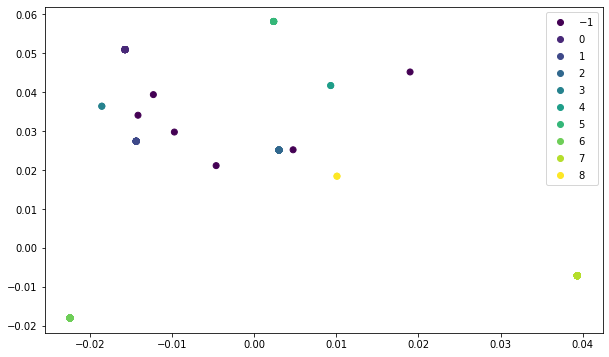

In [23]:
%pylab inline

data_2d_pca = reduce_dim_pca(2, vectors)

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=list(df["cluster"]))
pylab.legend(*scat.legend_elements(num="auto"))

In [24]:
aggregate_logs(df, json_logs, clusters)

['<13>Dec  3 03:15:23 U22020000000877 vectra_standard -: HOST [host@41261 category="HOST SCORING" hostName="Samsung-Galaxy-S7" currentIP="172.17.42.156" dvchost="172.17.18.39" threat="21" certainty="12" privilege="0" scoreDecreases="False" URL="https://172.17.18.39/hosts/14808" UTCTime="1638490523.952734" sourceKeyAsset="False" destKeyAsset="False" hostRoles=""]',
 '<13>Dec  1 16:11:53 U22020000000877 vectra_standard -: DETECT [detection@41261 category="INFO" type="Novel External Destination Port" hostname="fax.solidex.minsk.by" currentIP="172.17.15.3" dvchost="172.17.18.39" threat="0" certainty="0" URL="https://172.17.18.39/detections/3320?detail_id\\=244128" DestinationIP="93.125.5.100" DestinationDomain="sip.telecom.by" DestinationPort="11062" Proto="udp" triaged="False" BytesSent="6182540" BytesRcvd="6193376" UTCTimeStart="2021-11-25 11:53:09" UTCTimeEnd="2021-12-01 13:11:17"]',
 '<13>Dec  1 15:15:23 U22020000000877 vectra_standard -: HOST [host@41261 category="HOST SCORING" hostNa